In [ ]:
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip -P data
!cd data && unzip PennFudanPed.zip

--2025-04-12 11:20:37--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘data/PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  32.2MB/s    in 1.6s    

2025-04-12 11:20:39 (32.2 MB/s) - ‘data/PennFudanPed.zip’ saved [53723336/53723336]

Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: PennFudanPed/Annotation/FudanPed00002.txt  
  inflating: PennFudanPed/Annotation/FudanPed00003.txt  
  inflating: PennFudanPed/Annotation/FudanPed00004.txt  
  inflating: PennFudanPed/Annotation/FudanPed00005.txt  
  inflating: PennFudanPe

In [ ]:
# Install dependencies
!pip install ultralytics --quiet
!pip install -U torch torchvision --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.5/974.5 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 837.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.3 MB/s eta 0:00:00


In [ ]:
import os
import torch
import torchvision
from PIL import Image
import numpy as np
from tqdm import tqdm
import shutil

In [ ]:
import torch.utils.data
from PIL import Image

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

In [ ]:
!pip install --upgrade opencv-python

# Load data

In [ ]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {
            "boxes": tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img)),
            "masks": tv_tensors.Mask(masks),
            "labels": labels,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd
        }

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
root = 'data/PennFudanPed'
dataset = PennFudanDataset(root)

os.makedirs('pennfudan_yolo/images/train', exist_ok=True)
os.makedirs('pennfudan_yolo/images/val', exist_ok=True)
os.makedirs('pennfudan_yolo/images/test', exist_ok=True)
os.makedirs('pennfudan_yolo/labels/train', exist_ok=True)
os.makedirs('pennfudan_yolo/labels/val', exist_ok=True)
os.makedirs('pennfudan_yolo/labels/test', exist_ok=True)

indices = list(range(len(dataset)))
np.random.shuffle(indices)

# Split 80% for training, 10% for validation, and 10% for testing
split_idx_train = int(0.8 * len(dataset))
split_idx_val = int(0.9 * len(dataset))

train_idx = indices[:split_idx_train]
val_idx = indices[split_idx_train:split_idx_val]
test_idx = indices[split_idx_val:]

In [ ]:
def convert_to_yolo(size, box):
    dw = 1. / size[0]
    dh = 1. / size[1]
    x = (box[0] + box[2]) / 2.0
    y = (box[1] + box[3]) / 2.0
    w = box[2] - box[0]
    h = box[3] - box[1]
    return (x*dw, y*dh, w*dw, h*dh)

def is_valid_yolo_box(x, y, w, h):
    return all(0 <= v <= 1 for v in [x, y, w, h])

for split, split_indices in zip(['train', 'val', 'test'], [train_idx, val_idx, test_idx]):
    for i in tqdm(split_indices):
        img, target = dataset[i]
        img_name = dataset.imgs[i].replace('.png', '')

        img_np = F.to_pil_image(img)
        img_path = f'pennfudan_yolo/images/{split}/{img_name}.jpg'
        img_np.save(img_path)

        w, h = img_np.size
        boxes = target['boxes'].to('cpu').data.numpy()
        yolo_labels = [convert_to_yolo((w, h), box) for box in boxes]
        label_path = f'pennfudan_yolo/labels/{split}/{img_name}.txt'

        with open(label_path, 'w') as f:
            for x, y, bw, bh in yolo_labels:
                f.write(f"0 {x} {y} {bw} {bh}\n")

100%|██████████| 17/17 [00:00<00:00, 52.94it/s]


In [ ]:
# @title
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F

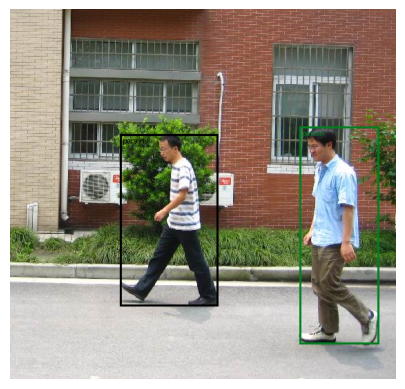

In [ ]:
# @title
# Assuming img and target are obtained from your dataset
img, target = dataset[0]  # Example image and target

# Convert the tv_tensors.Image (or your image tensor) to a PIL Image first
img_pil = F.to_pil_image(img)

# Now convert the PIL image to a torch tensor
img_tensor = F.to_tensor(img_pil)

# Get bounding boxes (ensure boxes is a tensor)
boxes = target['boxes']

# Convert numeric labels tensor to a list of strings.
# If you have only one class, for example "person", then:
labels_tensor = target['labels']
labels_list = ["person" for _ in range(len(labels_tensor))]

# Visualize the bounding boxes on the tensor image
img_with_boxes = draw_bounding_boxes(img_tensor, boxes, labels=labels_list, width=3)

# Convert the result back to a PIL Image for display with matplotlib
img_with_boxes_pil = F.to_pil_image(img_with_boxes)

# Show the image with bounding boxes
plt.imshow(img_with_boxes_pil)
plt.axis('off')
plt.show()


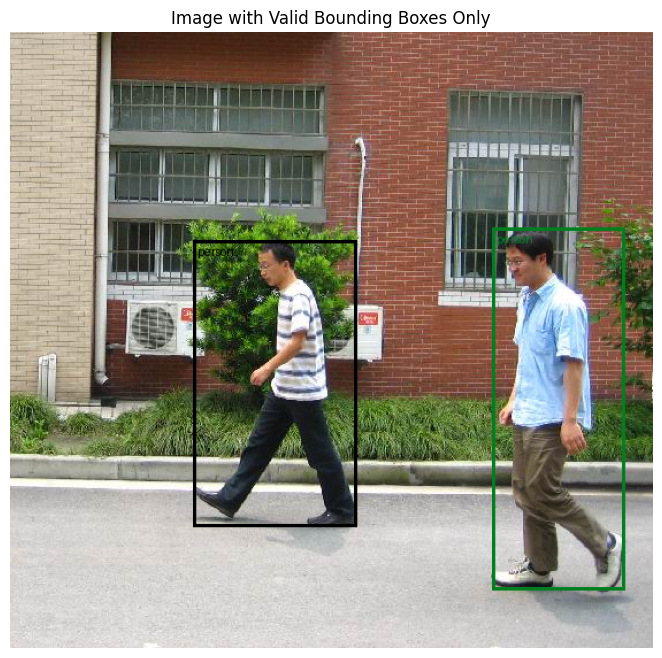

In [ ]:
# @title
def is_valid_box(box, img_width, img_height):
    # A valid box has x1 and y1 >= 0, x2 and y2 <= width/height, and x1 < x2, y1 < y2
    x1, y1, x2, y2 = box.tolist()  # convert tensor to list
    return (0 <= x1 < x2 <= img_width) and (0 <= y1 < y2 <= img_height)

img_height = img_tensor.shape[1]  # tensor shape is (C, H, W)
img_width = img_tensor.shape[2]

# Filter valid bounding boxes and their labels
valid_boxes = []
valid_labels = []
for box, label in zip(boxes, labels_list):
    if is_valid_box(box, img_width, img_height):
        valid_boxes.append(box)
        valid_labels.append(label)

if valid_boxes:  # check if there is at least one valid bounding box
    valid_boxes_tensor = torch.stack(valid_boxes)
    img_with_valid_boxes = draw_bounding_boxes(img_tensor, valid_boxes_tensor, labels=valid_labels, width=3)
    img_valid_pil = F.to_pil_image(img_with_valid_boxes)

    plt.figure(figsize=(10, 8))
    plt.title("Image with Valid Bounding Boxes Only")
    plt.imshow(img_valid_pil)
    plt.axis('off')
    plt.show()
else:
    print("No valid bounding boxes to display.")

# Create YOLO config yaml

In [ ]:
with open('pennfudan.yaml', 'w') as f:
    f.write(f'''
path: {os.path.abspath("pennfudan_yolo")}
train: images/train
test: images/test
val: images/val

nc: 1
names: ['person']
''')

In [ ]:
from ultralytics import YOLO

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Detection

## Train

In [ ]:
model = YOLO('yolov8n.pt')
results = model.train(
    data='pennfudan.yaml',
    epochs=20,
    imgsz=640,
    project='yolo_pennfudan',
    name='exp',
    save=True,
    save_period=1,
    val=True,
    device=device
)

Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=pennfudan.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=1, cache=False, device=cuda, workers=8, project=yolo_pennfudan, name=exp4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None

train: Scanning /content/pennfudan_yolo/labels/train... 164 images, 0 backgrounds, 0 corrupt: 100%|██████████| 164/164 [00:00<00:00, 2751.56it/s]

train: New cache created: /content/pennfudan_yolo/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/pennfudan_yolo/labels/val... 48 images, 0 backgrounds, 0 corrupt: 100%|██████████| 48/48 [00:00<00:00, 1002.10it/s]

val: New cache created: /content/pennfudan_yolo/labels/val.cache


Plotting labels to yolo_pennfudan/exp4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to yolo_pennfudan/exp4
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.18G     0.9411      2.246      1.158         24        640: 100%|██████████| 11/11 [00:03<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.72it/s]

                   all         48        119     0.0143          1      0.838      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.34G     0.8349      1.176       1.08         27        640: 100%|██████████| 11/11 [00:02<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]

                   all         48        119      0.978      0.374      0.817      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.34G     0.8719      1.039      1.084         20        640: 100%|██████████| 11/11 [00:02<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.68it/s]

                   all         48        119      0.962      0.647      0.839      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.34G      0.868       1.05      1.094         23        640: 100%|██████████| 11/11 [00:02<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.75it/s]

                   all         48        119      0.944      0.711      0.901      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.34G     0.8755      1.032       1.11         12        640: 100%|██████████| 11/11 [00:02<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.01it/s]

                   all         48        119      0.969      0.532      0.801      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.34G     0.8569      1.016      1.105         20        640: 100%|██████████| 11/11 [00:02<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.34it/s]

                   all         48        119      0.807      0.563      0.692      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.34G     0.8541     0.9729      1.096         20        640: 100%|██████████| 11/11 [00:02<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.90it/s]

                   all         48        119      0.897      0.866      0.937       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.34G     0.8472     0.9238      1.075         21        640: 100%|██████████| 11/11 [00:02<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.86it/s]

                   all         48        119      0.925      0.825      0.921      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.34G     0.8981     0.9703      1.124         13        640: 100%|██████████| 11/11 [00:02<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.49it/s]

                   all         48        119      0.952      0.899      0.966      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.34G     0.8442     0.8778      1.055         23        640: 100%|██████████| 11/11 [00:02<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.70it/s]

                   all         48        119      0.948      0.866      0.955      0.726


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.34G     0.6973      1.015     0.9909          6        640: 100%|██████████| 11/11 [00:03<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.96it/s]

                   all         48        119      0.957      0.937      0.961      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.34G     0.7003     0.9398     0.9913          9        640: 100%|██████████| 11/11 [00:02<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.24it/s]

                   all         48        119      0.967      0.924      0.986      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.34G     0.6963     0.8763     0.9929          6        640: 100%|██████████| 11/11 [00:02<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.09it/s]

                   all         48        119      0.957      0.958      0.987      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.34G     0.6355     0.8086     0.9687          9        640: 100%|██████████| 11/11 [00:02<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.68it/s]

                   all         48        119       0.98      0.975      0.994      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.34G     0.6494     0.8136     0.9803          9        640: 100%|██████████| 11/11 [00:02<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.00it/s]

                   all         48        119      0.983      0.948      0.992      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.34G     0.6015      0.783     0.9756          9        640: 100%|██████████| 11/11 [00:03<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]

                   all         48        119      0.964      0.983      0.993      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.34G     0.6183     0.7366     0.9707          9        640: 100%|██████████| 11/11 [00:02<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.84it/s]

                   all         48        119      0.975       0.99      0.994       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.34G     0.5761     0.7047     0.9237         10        640: 100%|██████████| 11/11 [00:02<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.13it/s]

                   all         48        119      0.983      0.982      0.994      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.34G      0.518     0.6691     0.9153         13        640: 100%|██████████| 11/11 [00:02<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.19it/s]

                   all         48        119      0.996      0.975      0.994      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.34G     0.4812     0.6356     0.9064         10        640: 100%|██████████| 11/11 [00:03<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.48it/s]


                   all         48        119      0.994      0.975      0.994      0.904

20 epochs completed in 0.022 hours.
Optimizer stripped from yolo_pennfudan/exp4/weights/last.pt, 6.2MB
Optimizer stripped from yolo_pennfudan/exp4/weights/best.pt, 6.2MB

Validating yolo_pennfudan/exp4/weights/best.pt...
Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.14it/s]


                   all         48        119      0.994      0.975      0.994      0.904
Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to yolo_pennfudan/exp4


## Evaluate

In [ ]:
metrics = model.val()

Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/pennfudan_yolo/labels/val.cache... 48 images, 0 backgrounds, 0 corrupt: 100%|██████████| 48/48 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.32it/s]


                   all         48        119      0.994      0.975      0.994      0.903
Speed: 6.2ms preprocess, 9.5ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to yolo_pennfudan/exp42
Evaluation Metrics:
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79f53f82c550>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,

In [ ]:
exp_path = os.path.join('yolo_pennfudan', 'exp', 'weights')
shutil.copy(os.path.join(exp_path, 'best.pt'), './best_model.pt')
shutil.copy(os.path.join(exp_path, 'last.pt'), './last_model.pt')

'./last_model.pt'

In [ ]:
from google.colab import files
files.download('best_model.pt')
files.download('last_model.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Test

In [ ]:
metrics = model.val(data='pennfudan.yaml', split='test')

Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)


val: Scanning /content/pennfudan_yolo/labels/test... 17 images, 0 backgrounds, 0 corrupt: 100%|██████████| 17/17 [00:00<00:00, 1683.03it/s]

val: New cache created: /content/pennfudan_yolo/labels/test.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.74it/s]


                   all         17         44      0.954          1      0.993      0.911
Speed: 0.2ms preprocess, 18.7ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to yolo_pennfudan/exp45


# Segmentation

In [ ]:
import cv2
import json

def mask_to_polygons(mask):
    # Convert single-channel binary mask
    mask = mask.numpy().astype(np.uint8)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    polygons = []
    for cnt in contours:
        if len(cnt) >= 3:  # YOLOv8 requires at least 3 points
            poly = cnt.reshape(-1).tolist()
            polygons.append(poly)
    return polygons

def save_yolo_seg_label(file_path, boxes, polygons, image_width, image_height):
    with open(file_path, 'w') as f:
        for box, seg in zip(boxes, polygons):
            x1, y1, x2, y2 = box.tolist()
            x_c = (x1 + x2) / 2
            y_c = (y1 + y2) / 2
            w = x2 - x1
            h = y2 - y1

            # Normalize bbox
            x_c /= image_width
            y_c /= image_height
            w /= image_width
            h /= image_height

            seg_str = ""
            for i in range(0, len(seg), 2):
                x = min(max(seg[i] / image_width, 0.0), 1.0)
                y = min(max(seg[i+1] / image_height, 0.0), 1.0)
                seg_str += f" {x:.6f} {y:.6f}"

            if 0 <= x_c <= 1 and 0 <= y_c <= 1:
                f.write(f"0 {x_c:.6f} {y_c:.6f} {w:.6f} {h:.6f}{seg_str}\n")

splits = {'train': train_idx, 'val': val_idx, 'test': test_idx}

for split, indices in splits.items():
    for idx in tqdm(indices, desc=f"Processing {split} set"):
        img, target = dataset[idx]

        img_path = f"pennfudan_yolo/images/{split}/{idx:04d}.jpg"
        torchvision.utils.save_image(img.float() / 255.0, img_path)

        # Convert masks to polygons
        yolo_polygons = []
        for i in range(target['masks'].shape[0]):
            poly = mask_to_polygons(target['masks'][i])
            if len(poly) > 0:
                yolo_polygons.append(poly[0])  # Take the outermost contour

        image_width = img.shape[2]
        image_height = img.shape[1]

        if len(yolo_polygons) > 0:
            save_yolo_seg_label(
                f"pennfudan_yolo/labels/{split}/{idx:04d}.txt",
                target['boxes'],
                yolo_polygons,
                image_width,
                image_height
            )

Processing test set: 100%|██████████| 17/17 [00:00<00:00, 26.16it/s]


In [ ]:
print(img.shape[2], img.shape[1])

462 387


In [ ]:
with open('pennfudan.yaml', 'w') as f:
    f.write(f'''
path: {os.path.abspath("pennfudan_yolo")}
train: images/train
test: images/test
val: images/val

nc: 1
names: ['person']
''')

## Train

In [ ]:
from ultralytics import YOLO

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
model = YOLO('yolov8n-seg.pt')
model.train(data='pennfudan.yaml', epochs=100, imgsz=512, device = device)

100%|██████████| 6.74M/6.74M [00:00<00:00, 110MB/s]

Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)


engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=pennfudan.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, simplif

100%|██████████| 755k/755k [00:00<00:00, 18.8MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 94.2MB/s]


AMP: checks passed ✅


train: Scanning /content/pennfudan_yolo/labels/train... 136 images, 0 backgrounds, 0 corrupt: 100%|██████████| 136/136 [00:00<00:00, 1328.16it/s]

train: New cache created: /content/pennfudan_yolo/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/pennfudan_yolo/labels/val... 17 images, 0 backgrounds, 0 corrupt: 100%|██████████| 17/17 [00:00<00:00, 620.03it/s]

val: New cache created: /content/pennfudan_yolo/labels/val.cache


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100      1.76G      1.383      4.877      2.497      1.459         55        512: 100%|██████████| 9/9 [00:06<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.39it/s]

                   all         17         53     0.0102      0.981       0.26      0.136    0.00294      0.283     0.0705     0.0135



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100      1.86G      1.283      3.929      1.822      1.413         27        512: 100%|██████████| 9/9 [00:02<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]

                   all         17         53      0.267      0.849      0.454       0.24     0.0106      0.264      0.085     0.0242



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100      1.89G      1.334      3.658      1.627        1.4         56        512: 100%|██████████| 9/9 [00:02<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]

                   all         17         53      0.445       0.66       0.44      0.195     0.0625      0.132     0.0219    0.00685



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100       1.9G      1.309      3.571      1.602       1.41         32        512: 100%|██████████| 9/9 [00:02<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

                   all         17         53      0.386      0.528      0.414      0.197      0.185      0.113     0.0495     0.0135



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100      1.93G      1.311      3.482      1.556      1.407         52        512: 100%|██████████| 9/9 [00:02<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.47it/s]

                   all         17         53      0.489      0.585      0.369      0.168     0.0921      0.101     0.0208     0.0059



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100      1.95G      1.287      3.536      1.579      1.392         46        512: 100%|██████████| 9/9 [00:02<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]

                   all         17         53      0.504      0.509      0.517      0.217    0.00925     0.0189   0.000743   0.000281



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100      1.96G      1.322      3.522      1.501      1.421         58        512: 100%|██████████| 9/9 [00:02<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]

                   all         17         53      0.397      0.585      0.387       0.17      0.429      0.113     0.0997     0.0192



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100      1.98G      1.304      3.557      1.516      1.415         49        512: 100%|██████████| 9/9 [00:02<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.16it/s]

                   all         17         53      0.331      0.468       0.29      0.105      0.282      0.113     0.0464     0.0112



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100         2G      1.336      3.526      1.487      1.416         56        512: 100%|██████████| 9/9 [00:02<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.55it/s]


                   all         17         53      0.443      0.509      0.361      0.172      0.127      0.132     0.0346     0.0107

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.02G      1.285      3.458      1.513      1.405         55        512: 100%|██████████| 9/9 [00:02<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]

                   all         17         53      0.217      0.472      0.228     0.0832     0.0475      0.151     0.0102    0.00182



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.04G      1.288       3.51      1.527      1.409         53        512: 100%|██████████| 9/9 [00:02<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]

                   all         17         53      0.262      0.453      0.189     0.0768     0.0399     0.0755    0.00497    0.00141



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.05G       1.31      3.492      1.502      1.439         54        512: 100%|██████████| 9/9 [00:02<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]

                   all         17         53      0.361      0.283      0.256     0.0766     0.0199     0.0755    0.00237   0.000492



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.06G      1.301      3.432      1.527      1.435         53        512: 100%|██████████| 9/9 [00:02<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]

                   all         17         53      0.434      0.453      0.361      0.139     0.0859     0.0943     0.0274     0.0105



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.09G      1.283      3.448      1.443      1.403         60        512: 100%|██████████| 9/9 [00:02<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]

                   all         17         53      0.412      0.528      0.379       0.17      0.237      0.113      0.065     0.0255



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.11G      1.251      3.299      1.455      1.394         47        512: 100%|██████████| 9/9 [00:02<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]

                   all         17         53      0.328      0.432      0.338      0.157      0.172      0.151     0.0593      0.015



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.13G      1.297      3.376      1.476      1.421         43        512: 100%|██████████| 9/9 [00:02<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

                   all         17         53      0.383      0.491      0.385      0.148     0.0306     0.0377    0.00559    0.00256



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.14G      1.256      3.357      1.448      1.407         49        512: 100%|██████████| 9/9 [00:02<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]

                   all         17         53       0.48       0.68      0.566       0.27     0.0862      0.189     0.0248    0.00858



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.17G      1.297      3.371       1.45      1.407         40        512: 100%|██████████| 9/9 [00:02<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]

                   all         17         53      0.443      0.679      0.493      0.249      0.119      0.189     0.0514     0.0142



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.18G       1.27      3.285      1.421      1.417         50        512: 100%|██████████| 9/9 [00:02<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]

                   all         17         53      0.378      0.472      0.442      0.197      0.406     0.0566     0.0503    0.00855



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100       2.2G      1.215      3.349      1.357      1.356         57        512: 100%|██████████| 9/9 [00:02<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]

                   all         17         53      0.571      0.427      0.473      0.207     0.0447     0.0943       0.01    0.00177



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.21G      1.198      3.268      1.357       1.36         41        512: 100%|██████████| 9/9 [00:02<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]

                   all         17         53      0.572      0.706      0.616      0.302      0.293       0.17     0.0862     0.0252



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.24G      1.213      3.285      1.361      1.349         46        512: 100%|██████████| 9/9 [00:02<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]

                   all         17         53      0.592      0.711      0.637      0.335      0.396      0.208      0.165     0.0497



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.26G      1.239      3.282      1.385      1.388         55        512: 100%|██████████| 9/9 [00:02<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]

                   all         17         53      0.624      0.547      0.597        0.3      0.349      0.264      0.193     0.0603



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.28G      1.183       3.25      1.344      1.353         45        512: 100%|██████████| 9/9 [00:02<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]

                   all         17         53      0.574      0.679      0.665      0.304      0.135       0.17     0.0396     0.0108



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.28G      1.223      3.225      1.387      1.379         42        512: 100%|██████████| 9/9 [00:02<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]

                   all         17         53      0.553      0.629      0.602       0.27      0.144      0.189     0.0515     0.0135



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.31G      1.194      3.298      1.319      1.352         59        512: 100%|██████████| 9/9 [00:02<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

                   all         17         53      0.621      0.681      0.541      0.251      0.193      0.208     0.0948     0.0295



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.33G      1.174      3.195      1.316      1.365         37        512: 100%|██████████| 9/9 [00:02<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]

                   all         17         53      0.518      0.736       0.53      0.243       0.17      0.264     0.0943     0.0315



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.35G      1.235      3.345      1.376      1.395         36        512: 100%|██████████| 9/9 [00:02<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]

                   all         17         53      0.478      0.736      0.502      0.263      0.155       0.17       0.09     0.0325



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.36G      1.179       3.19      1.312      1.342         26        512: 100%|██████████| 9/9 [00:02<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]

                   all         17         53      0.463      0.698       0.52      0.292      0.547      0.283      0.241     0.0754



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.39G      1.202      3.233      1.328      1.369         60        512: 100%|██████████| 9/9 [00:02<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]

                   all         17         53      0.638      0.717      0.666      0.373      0.354      0.238       0.21     0.0775



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.41G      1.229      3.255      1.343      1.367         43        512: 100%|██████████| 9/9 [00:02<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]

                   all         17         53      0.638      0.731      0.618      0.332      0.151      0.208      0.103     0.0388



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.42G      1.113      3.141      1.273      1.292         44        512: 100%|██████████| 9/9 [00:02<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.41it/s]

                   all         17         53      0.521      0.736      0.568      0.297      0.147      0.208     0.0517     0.0164



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.43G      1.112      3.142      1.254      1.288         50        512: 100%|██████████| 9/9 [00:02<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]

                   all         17         53      0.458      0.679      0.561      0.274     0.0892      0.132     0.0387     0.0121



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.46G       1.13      3.141      1.217      1.291         46        512: 100%|██████████| 9/9 [00:02<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]

                   all         17         53      0.547      0.615       0.61      0.307      0.247      0.151     0.0812     0.0299



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.48G       1.12      3.173      1.242      1.295         71        512: 100%|██████████| 9/9 [00:02<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

                   all         17         53      0.464       0.66      0.493      0.258      0.235      0.189     0.0872     0.0337



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/100       2.5G      1.151      3.165      1.284      1.319         45        512: 100%|██████████| 9/9 [00:02<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.34it/s]

                   all         17         53      0.554      0.632      0.559      0.262      0.224      0.189     0.0909     0.0328



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.51G      1.053      3.082      1.188       1.26         42        512: 100%|██████████| 9/9 [00:02<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]

                   all         17         53       0.68      0.566      0.589      0.291      0.187      0.283      0.115     0.0467



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.54G      1.095      3.082      1.249      1.313         46        512: 100%|██████████| 9/9 [00:02<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

                   all         17         53      0.447      0.755      0.555      0.268      0.144      0.245     0.0823     0.0332



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.55G      1.122      3.088      1.206      1.302         51        512: 100%|██████████| 9/9 [00:02<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]

                   all         17         53      0.521      0.679      0.613      0.329      0.182      0.264     0.0906     0.0283



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.57G      1.074      3.104      1.207      1.302         34        512: 100%|██████████| 9/9 [00:02<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.88it/s]

                   all         17         53      0.668      0.642      0.635      0.349      0.218       0.34      0.109     0.0332



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.58G      1.126      3.133      1.208      1.326         49        512: 100%|██████████| 9/9 [00:02<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

                   all         17         53      0.449      0.708      0.568      0.278      0.158      0.264     0.0874     0.0242



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.61G      1.086      3.015      1.198      1.297         43        512: 100%|██████████| 9/9 [00:02<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]

                   all         17         53      0.616      0.728      0.721      0.413      0.257      0.245      0.147     0.0523



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.63G      1.075      3.029      1.198      1.288         54        512: 100%|██████████| 9/9 [00:02<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]

                   all         17         53      0.732      0.755      0.809       0.48      0.485      0.377      0.316     0.0986



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.65G      1.048      2.926      1.137      1.249         42        512: 100%|██████████| 9/9 [00:03<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.28it/s]

                   all         17         53      0.579      0.702      0.659      0.366      0.278       0.29      0.168     0.0556



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.65G      1.067      2.926      1.089      1.265         56        512: 100%|██████████| 9/9 [00:02<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]

                   all         17         53      0.757      0.642      0.706      0.422      0.514      0.283      0.267      0.082



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.68G      1.108      3.054      1.165      1.304         71        512: 100%|██████████| 9/9 [00:02<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]

                   all         17         53      0.635      0.547      0.528      0.307      0.323       0.28      0.156     0.0517



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/100       2.7G      1.015      2.938       1.13      1.238         42        512: 100%|██████████| 9/9 [00:02<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]

                   all         17         53      0.464      0.472      0.415      0.203     0.0631       0.17     0.0364     0.0111



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.72G      1.016      2.873      1.119      1.239         44        512: 100%|██████████| 9/9 [00:02<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]

                   all         17         53      0.662      0.481      0.542      0.299      0.153      0.415     0.0959     0.0306



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.73G      1.049          3      1.128      1.264         42        512: 100%|██████████| 9/9 [00:02<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]

                   all         17         53      0.656      0.613      0.577       0.33      0.218      0.264      0.128     0.0493



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.76G      1.011      2.911      1.102      1.242         50        512: 100%|██████████| 9/9 [00:02<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]

                   all         17         53      0.569      0.566      0.551      0.286       0.16      0.245     0.0926     0.0354



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.78G       1.05      3.033      1.129      1.254         43        512: 100%|██████████| 9/9 [00:02<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]

                   all         17         53      0.536      0.566      0.475      0.222      0.218      0.264     0.0965     0.0369



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.79G      1.005      2.882      1.057      1.215         42        512: 100%|██████████| 9/9 [00:02<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.20it/s]


                   all         17         53      0.555       0.66      0.522      0.272      0.298      0.302      0.177     0.0567

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/100       2.8G     0.9859       2.85      1.002      1.199         53        512: 100%|██████████| 9/9 [00:03<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]

                   all         17         53      0.547      0.717      0.551      0.274      0.316      0.321      0.169     0.0605



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.83G      1.024      2.878      1.058      1.259         50        512: 100%|██████████| 9/9 [00:02<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]

                   all         17         53      0.477      0.679      0.471      0.242      0.195      0.283      0.103     0.0406



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.85G      1.006      2.785      1.032      1.221         50        512: 100%|██████████| 9/9 [00:02<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]

                   all         17         53      0.584      0.688       0.59      0.328      0.256      0.264      0.142     0.0564



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.87G     0.9672      2.845          1      1.222         39        512: 100%|██████████| 9/9 [00:02<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.33it/s]

                   all         17         53      0.661      0.717      0.648      0.372      0.359      0.358      0.199     0.0638



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.88G     0.9416      2.716     0.9922      1.191         45        512: 100%|██████████| 9/9 [00:02<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]

                   all         17         53        0.6      0.698       0.57      0.294      0.245      0.283      0.137       0.05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/100       2.9G     0.9865       2.85     0.9993      1.229         68        512: 100%|██████████| 9/9 [00:02<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]

                   all         17         53      0.573      0.736      0.568      0.316      0.421      0.377      0.249     0.0731



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.92G     0.9679       2.75     0.9906      1.209         48        512: 100%|██████████| 9/9 [00:02<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]

                   all         17         53      0.687      0.717      0.611      0.347      0.363      0.377       0.23     0.0717



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.94G     0.9333      2.674     0.9793      1.182         50        512: 100%|██████████| 9/9 [00:02<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]

                   all         17         53      0.476      0.514      0.473      0.217       0.12      0.245     0.0584     0.0172



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.95G     0.9749      2.822      1.031      1.207         69        512: 100%|██████████| 9/9 [00:02<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

                   all         17         53      0.443      0.698      0.483      0.234      0.168      0.245     0.0712     0.0235



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.98G     0.9467      2.778     0.9958      1.205         30        512: 100%|██████████| 9/9 [00:02<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]

                   all         17         53      0.554       0.66      0.531      0.282      0.244      0.245      0.116     0.0324



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/100         3G     0.9654      2.725      1.019      1.203         33        512: 100%|██████████| 9/9 [00:02<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]

                   all         17         53      0.678      0.585      0.677      0.394      0.288      0.358      0.209     0.0499



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/100      3.02G     0.9676      2.752     0.9991      1.215         51        512: 100%|██████████| 9/9 [00:02<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


                   all         17         53      0.751      0.377      0.535      0.285      0.175      0.264      0.145      0.038

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/100      3.02G     0.9157      2.744     0.9551      1.197         54        512: 100%|██████████| 9/9 [00:02<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]

                   all         17         53      0.612      0.472      0.603      0.345      0.354       0.28      0.212     0.0546



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/100      3.05G     0.9347      2.644     0.9164      1.174         68        512: 100%|██████████| 9/9 [00:02<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]

                   all         17         53      0.635      0.717      0.754       0.42      0.275      0.377      0.199     0.0495



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/100      3.07G     0.9344      2.776     0.9469      1.194         43        512: 100%|██████████| 9/9 [00:02<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.61it/s]

                   all         17         53      0.799      0.774      0.826      0.468      0.385      0.396      0.274     0.0824



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/100      3.09G     0.8992      2.718     0.9231      1.166         52        512: 100%|██████████| 9/9 [00:02<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]

                   all         17         53      0.684      0.623      0.667      0.363      0.277      0.264      0.159     0.0545



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/100       3.1G     0.9103      2.681     0.9363      1.186         36        512: 100%|██████████| 9/9 [00:02<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


                   all         17         53      0.619      0.717      0.695      0.385      0.296      0.283       0.19     0.0719

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/100      3.13G     0.8975      2.682     0.8802      1.186         51        512: 100%|██████████| 9/9 [00:02<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]

                   all         17         53       0.56      0.811      0.683       0.37      0.358      0.264      0.187     0.0621



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/100      3.15G      0.901      2.644     0.9215      1.189         48        512: 100%|██████████| 9/9 [00:02<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]

                   all         17         53      0.638      0.566      0.642      0.338      0.318      0.334      0.172     0.0465



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/100      3.17G     0.8662      2.619     0.8428      1.151         39        512: 100%|██████████| 9/9 [00:02<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


                   all         17         53      0.681      0.698        0.7      0.423      0.357       0.34      0.194     0.0648

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/100      3.17G     0.8882       2.59     0.9135      1.167         32        512: 100%|██████████| 9/9 [00:02<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]

                   all         17         53      0.615      0.811      0.665      0.365      0.306      0.358      0.188     0.0558



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/100       3.2G     0.8519      2.587     0.8661      1.143         59        512: 100%|██████████| 9/9 [00:02<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.31it/s]

                   all         17         53      0.548      0.641      0.502      0.258      0.199      0.283     0.0895     0.0325



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/100      3.22G     0.8974       2.51     0.8688      1.159         50        512: 100%|██████████| 9/9 [00:02<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]

                   all         17         53      0.472      0.566      0.439      0.209      0.156      0.283     0.0773     0.0284



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/100      3.24G     0.8557      2.522     0.8612      1.152         44        512: 100%|██████████| 9/9 [00:02<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


                   all         17         53       0.41      0.564       0.47      0.241      0.224      0.264       0.12     0.0374

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/100      3.24G     0.8394      2.561     0.8523      1.144         54        512: 100%|██████████| 9/9 [00:02<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]

                   all         17         53      0.514      0.558      0.541      0.298      0.275      0.302      0.152     0.0527



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/100      3.28G     0.8732      2.484     0.9081      1.173         30        512: 100%|██████████| 9/9 [00:02<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]

                   all         17         53      0.716      0.604      0.721      0.422      0.427      0.358      0.281     0.0998



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/100      3.29G     0.8371      2.511     0.8182      1.125         63        512: 100%|██████████| 9/9 [00:02<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]

                   all         17         53       0.91      0.528      0.722      0.439      0.513      0.302      0.296        0.1



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/100      3.31G     0.8228      2.451     0.8471      1.107         44        512: 100%|██████████| 9/9 [00:02<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.34it/s]

                   all         17         53      0.529      0.642      0.578      0.317      0.259      0.302      0.151     0.0515



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/100      3.32G     0.8737      2.427     0.8472      1.149         55        512: 100%|██████████| 9/9 [00:02<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


                   all         17         53      0.523      0.585      0.503      0.273      0.201      0.245      0.112     0.0378

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/100      3.35G     0.7987      2.498     0.8344      1.119         33        512: 100%|██████████| 9/9 [00:02<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]

                   all         17         53      0.673       0.66      0.627      0.381       0.36       0.34      0.222      0.076



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/100      3.37G     0.8218      2.504     0.8043       1.12         49        512: 100%|██████████| 9/9 [00:02<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]

                   all         17         53      0.795      0.698      0.773      0.495       0.43      0.377       0.31      0.121



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/100      3.39G     0.8327      2.473     0.8209       1.13         57        512: 100%|██████████| 9/9 [00:03<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.94it/s]

                   all         17         53      0.801      0.604      0.763      0.464      0.495      0.352       0.31       0.11



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/100      3.39G     0.8425      2.461     0.8273      1.142         51        512: 100%|██████████| 9/9 [00:02<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]

                   all         17         53      0.761      0.717      0.785      0.476       0.51       0.34      0.305      0.107



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/100      3.42G     0.8063      2.419     0.8296      1.137         29        512: 100%|██████████| 9/9 [00:02<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]

                   all         17         53      0.752      0.698      0.742      0.456      0.406      0.377      0.296      0.101



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/100      3.44G      0.817      2.428     0.8226      1.121         33        512: 100%|██████████| 9/9 [00:02<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]

                   all         17         53      0.824      0.642      0.765      0.471      0.425      0.396      0.298      0.102



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/100      3.46G     0.7904      2.394     0.7633      1.138         27        512: 100%|██████████| 9/9 [00:02<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]

                   all         17         53      0.763      0.642      0.732      0.442      0.326      0.415      0.258     0.0839



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/100      3.47G     0.7858       2.41     0.7938      1.109         46        512: 100%|██████████| 9/9 [00:02<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]

                   all         17         53      0.743       0.66      0.733      0.444      0.424      0.362      0.266     0.0965



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/100       3.5G     0.8138      2.404     0.8032      1.141         52        512: 100%|██████████| 9/9 [00:02<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]

                   all         17         53      0.754      0.642      0.741      0.451      0.408      0.377      0.299      0.105


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/100      3.52G     0.7081      2.267     0.8921      1.106         16        512: 100%|██████████| 9/9 [00:03<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]

                   all         17         53      0.767       0.66      0.776      0.464      0.432      0.396      0.282     0.0912



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/100      3.54G     0.6339      2.021     0.7237      1.046         17        512: 100%|██████████| 9/9 [00:02<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.60it/s]

                   all         17         53      0.736      0.679      0.768      0.459      0.323      0.358      0.203     0.0607



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/100      3.54G     0.6442       2.09     0.6949      1.083         20        512: 100%|██████████| 9/9 [00:01<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]

                   all         17         53      0.745       0.66      0.747      0.441      0.377       0.34      0.194     0.0613



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/100      3.57G     0.6503      2.015     0.7008      1.082         20        512: 100%|██████████| 9/9 [00:01<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.15it/s]

                   all         17         53      0.758       0.66      0.727      0.427      0.384       0.34      0.203     0.0745



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/100      3.59G     0.6631      2.027     0.6521      1.083         21        512: 100%|██████████| 9/9 [00:01<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]

                   all         17         53      0.698      0.642      0.707      0.421      0.354      0.358      0.204     0.0763



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/100      3.61G     0.6223      1.938     0.6072      1.063         31        512: 100%|██████████| 9/9 [00:01<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]

                   all         17         53      0.688      0.665      0.671      0.398      0.309      0.358      0.197     0.0764



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/100      3.62G     0.6283      2.004     0.6216      1.067         24        512: 100%|██████████| 9/9 [00:02<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]

                   all         17         53      0.659      0.692       0.66      0.382      0.375       0.34      0.214     0.0749



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/100      3.65G      0.581      1.879     0.5951      1.038         17        512: 100%|██████████| 9/9 [00:01<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.42it/s]

                   all         17         53      0.649      0.698      0.654      0.368      0.374       0.34      0.197     0.0655



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/100      3.67G      0.575      1.876     0.5953      1.002         23        512: 100%|██████████| 9/9 [00:01<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.70it/s]

                   all         17         53      0.593      0.679      0.634      0.359      0.349      0.321      0.196     0.0655



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/100      3.68G     0.5954       1.91     0.5911      1.062         24        512: 100%|██████████| 9/9 [00:01<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.34it/s]

                   all         17         53      0.622       0.66       0.64      0.363      0.333      0.358        0.2     0.0677



100 epochs completed in 0.082 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 6.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 6.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-seg summary (fused): 85 layers, 3,258,259 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


                   all         17         53      0.794      0.698      0.771      0.491       0.43      0.377      0.312      0.123
Speed: 0.1ms preprocess, 1.6ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/segment/train


ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7aab65360750>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041, 

## Evaluate

In [ ]:
model.val()

Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-seg summary (fused): 85 layers, 3,258,259 parameters, 0 gradients, 12.0 GFLOPs


val: Scanning /content/pennfudan_yolo/labels/val.cache... 17 images, 0 backgrounds, 0 corrupt: 100%|██████████| 17/17 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:00<00:00,  2.10it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.41it/s]


                   all         17         51      0.697      0.804      0.804      0.511      0.402       0.51      0.369      0.109
Speed: 0.2ms preprocess, 8.6ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/segment/train62


ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a4654731910>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041, 

## Test

In [ ]:
model.val(split='test')

Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)


val: Scanning /content/pennfudan_yolo/labels/test... 17 images, 0 backgrounds, 0 corrupt: 100%|██████████| 17/17 [00:00<00:00, 1749.99it/s]

val: New cache created: /content/pennfudan_yolo/labels/test.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:00<00:00,  2.05it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]


                   all         17         42      0.724      0.667      0.742      0.412      0.444      0.476      0.366      0.102
Speed: 3.2ms preprocess, 6.2ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/segment/train63


ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a4655491390>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041, 